In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score #các chỉ số đánh giá
from sklearn import metrics

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/final_dw.csv')
display(final_df)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,120,360,1,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360,1,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360,1,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360,1,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360,1,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71,360,1,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40,180,1,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253,360,1,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187,360,1,Urban,Y


In [ ]:
# Chọn các cột cần sử dụng cho phân cụm
selected_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
data_selected = final_df[selected_columns]

# Xử lý giá trị thiếu (loại bỏ các hàng thiếu dữ liệu)
df_cleaned = data_selected.dropna()

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cleaned)


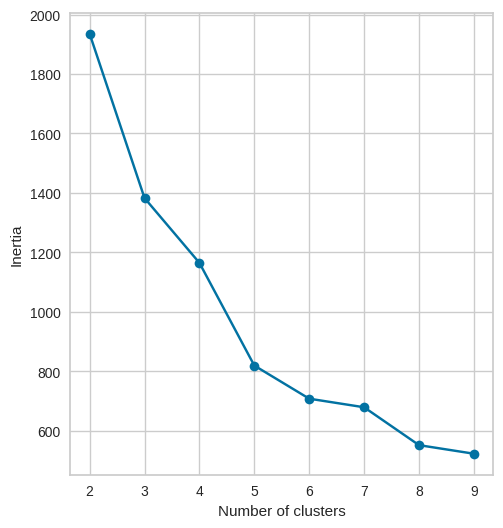

In [ ]:
# Xác định số cụm tối ưu bằng phương pháp Elbow
# Lấy dữ liệu đã được chuẩn hóa
X = data_scaled

# Tính toán inertia cho các giá trị k khác nhau
inertias = []

for n_clusters in range(2, 10): #chạy thử số cụm từ 2 đến 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Tạo biểu đồ Elbow để biểu thị số cụm tối ưu
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

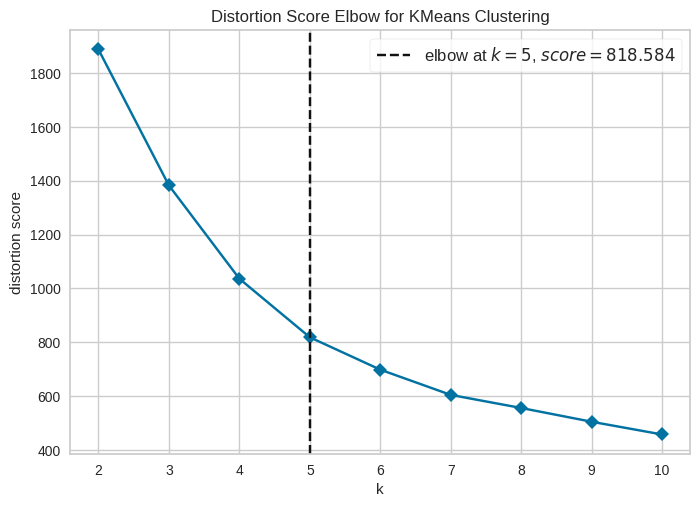

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(2,11),timings=False )
visualizer.fit(X)
visualizer.show()

In [ ]:
# Train lại mô hình với số cụm tối ưu đã tìm đc
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)

# Giảm chiều dữ liệu bằng PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(X)
centroids_2d = pca.transform(kmeans.cluster_centers_)

#tìm ra các tâm cụm tốt nhất để phân chia dữ liệu, dựa trên số cụm tối ưu đã xác định

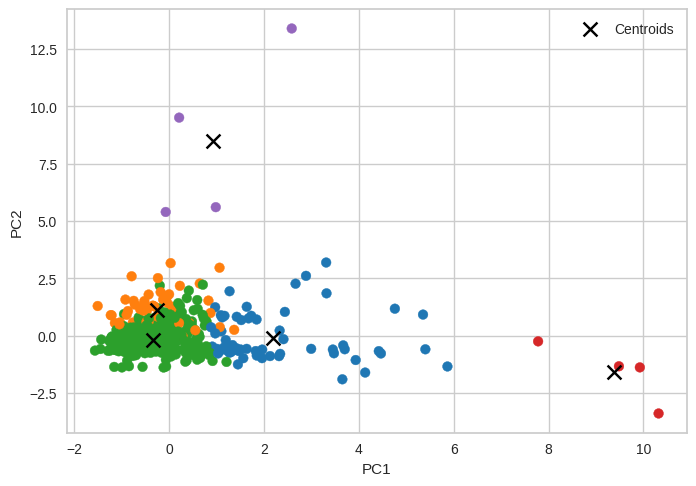

In [ ]:
# Vẽ biểu đồ trực quan dữ liệu sau khi đã phân cụm
k = 5
colors = sns.color_palette('tab10', k)

plt.scatter(data_2d[:, 0], data_2d[:, 1], c=[colors[label] for label in kmeans.labels_]) # Vẽ điểm dlieu
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='black', marker='x', s=100, label='Centroids')  # Vẽ tâm cụm
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [ ]:
# Tính Silhouette Score (cao hơn tốt hơn, giá trị nằm trong khoảng [-1, 1])
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.5f}")
# Tính Davies-Bouldin Index (thấp hơn tốt hơn)
davies_bouldin = davies_bouldin_score(X, kmeans.labels_)
print(f"Davies-Bouldin Index: {davies_bouldin:.5f}")

Silhouette Score: 0.57035
Davies-Bouldin Index: 0.75683


KMEAN++

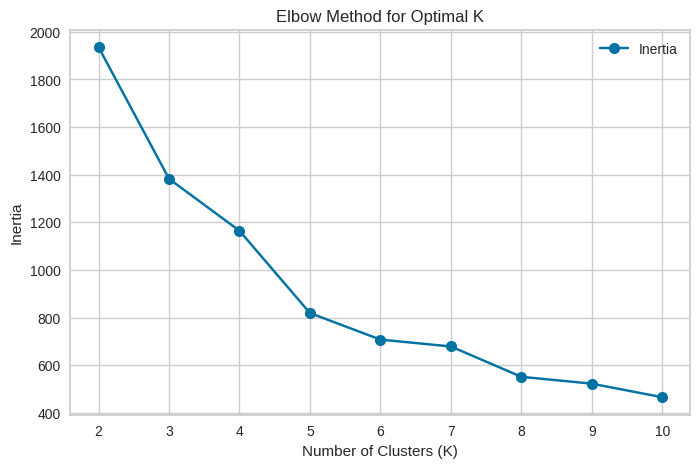

In [ ]:
# Xác định số cụm tối ưu bằng phương pháp Elbow
# Lấy dữ liệu từ các cột đã chọn
X = data_scaled

K = range(2, 11)
inertia_plus = []
for k in K:
    kmeans_plus = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_plus.fit(X)
    inertia_plus.append(kmeans_plus.inertia_)

# Vẽ đồ thị Elbow để tìm số cụm tối ưu
plt.figure(figsize=(8, 5))
plt.plot(K, inertia_plus, 'bo-', markersize=8, label='Inertia')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.legend()
plt.grid(True)
plt.show()


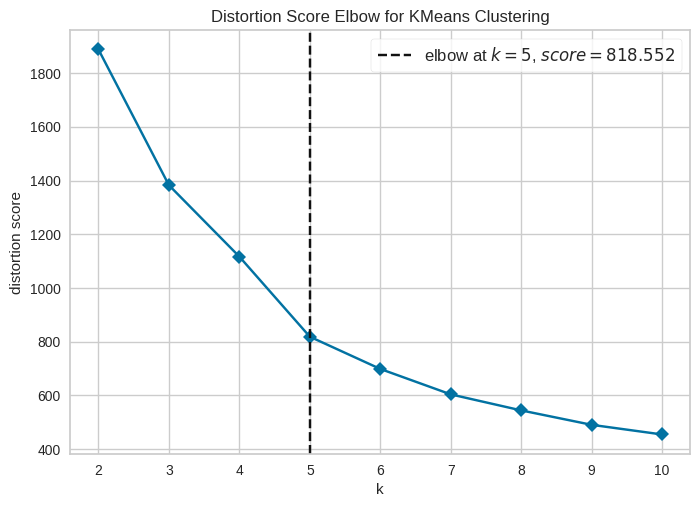

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans(init='k-means++', n_init=10, random_state=42)

# KElbowVisualizer
visualizer = KElbowVisualizer(model, k=(2, 11), timings=False)
visualizer.fit(X)
visualizer.show()

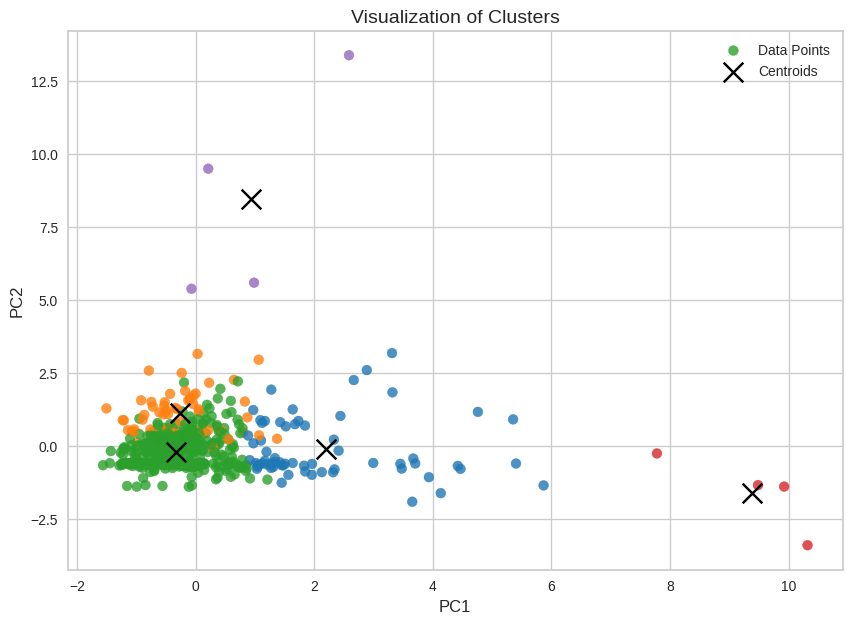

In [ ]:
# optimal_k = 5 là số cụm tối ưu đã được xác định
optimal_k = 5

# Khởi tạo và huấn luyện mô hình KMeans với số cụm tối ưu
kmean_plus = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmean_plus.fit(X)

# Giảm chiều dữ liệu xuống 2D bằng PCA để trực quan hóa
pca = PCA(n_components=2)
data_2d = pca.fit_transform(X)
centroids_2d = pca.transform(kmean_plus.cluster_centers_)

# Tạo bảng màu với 6 màu sắc từ seaborn
colors = sns.color_palette('tab10', optimal_k)

# Vẽ biểu đồ trực quan dữ liệu sau khi phân cụm
plt.figure(figsize=(10, 7))

# Vẽ các điểm dữ liệu và màu sắc theo nhãn cụm
plt.scatter(
    data_2d[:, 0], data_2d[:, 1],
    c=[colors[label] for label in kmean_plus.labels_],  # Màu sắc theo nhãn cụm
    s=50, alpha=0.8, label='Data Points'
)

# Vẽ tâm cụm
plt.scatter(
    centroids_2d[:, 0], centroids_2d[:, 1],
    c='black', marker='x', s=200, label='Centroids'
)

# Thêm nhãn, chú thích và lưới
plt.title('Visualization of Clusters', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

In [ ]:
# Tính Silhouette Score (cao hơn tốt hơn, giá trị nằm trong khoảng [-1, 1])
silhouette_avg = silhouette_score(X, kmean_plus.labels_)
print(f"Silhouette Score: {silhouette_avg:.5f}")
# Tính Davies-Bouldin Index (thấp hơn tốt hơn)
davies_bouldin = davies_bouldin_score(X, kmean_plus.labels_)
print(f"Davies-Bouldin Index: {davies_bouldin:.5f}")

Silhouette Score: 0.57035
Davies-Bouldin Index: 0.75683


In [ ]:
# Tạo một DataFrame mới chứa các cụm
df_clustered = df_cleaned.copy()
df_clustered['Cluster'] = kmean_plus.labels_

# Xem các cụm và số lượng khách hàng trong mỗi cụm
print(df_clustered['Cluster'].value_counts())

# Tính toán các chỉ số thống kê cho từng cụm
cluster_stats = df_clustered.groupby('Cluster').mean()
print(cluster_stats)

Cluster
2    486
0     63
1     57
3      4
4      4
Name: count, dtype: int64
         ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term
Cluster                                                                  
0           12494.142857        2011.396825  307.968254        360.000000
1            4756.614035        1488.101754  117.421053        162.105263
2            4150.236626        1375.310947  124.051440        362.222222
3           59024.750000           0.000000  537.500000        255.000000
4            1588.000000       28876.000000  195.500000        315.000000
